# Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
import re
import json
import imblearn
import sklearn.metrics as metrics
from collections import Counter
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import word_tokenize, RegexpTokenizer
from numpy import where
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler

# Opening Dataset and convert it into Array

In [2]:
dataset = []
with open ('../dataset/dataset.csv',encoding="latin1") as csvfile:
    readCSV = csv.DictReader(csvfile, delimiter=';')
    
    for row in readCSV:
        tweets = row['tweet']    
        usernames = row['username']
        hashtags = row['hashtag']
        dates = row['date']
        intent = row['intent']
        emotion = row['emotion']
        dataset.append({
            'date' : dates,
            'username' : usernames,
            'tweet' : tweets,
            'hashtag' : hashtags,
            'intent' : intent,
            'emotion' : emotion
        })
            
        
print("total tweets : " , len(dataset))

total tweets :  1734


# Normalization

The purpose of normalization are to remove non Indonesian word such as slang words and abbreviations will be converted to standard Indonesian words. the list is created by iterating to each feature in the dataset and list them with their normal word (standar word)

## Load list of typo words

In [3]:
typo_list = []
with open ('../feature_list/typo.csv',encoding="latin1") as csvfile:
    readCSV = csv.DictReader(csvfile, delimiter=',')
    for row in readCSV:
        word = row['typo']    
        standard_word = row['standard_form']
        typo_list.append({
            'word' : word,
            'standard_word' : standard_word
        })  
print("total typo words : " , len(typo_list))

total typo words :  169


## Load list of abbreviations words

In [4]:
abbreviation_list = []
with open ('../feature_list/abbreviation.csv',encoding="latin1") as csvfile:
    readCSV = csv.DictReader(csvfile, delimiter=',')
    for row in readCSV:
        word = row['abbreviations']    
        standard_word = row['non-abbreviations']
        abbreviation_list.append({
            'word' : word,
            'standard_word' : standard_word
        })      
print("total abbreviation words : " , len(abbreviation_list))

total abbreviation words :  362


## Load list of slang words

In [5]:
slang_list = []
with open ('../feature_list/slangwords.csv',encoding="latin1") as csvfile:
    readCSV = csv.DictReader(csvfile, delimiter=',')
    for row in readCSV:
        word = row['slang_word']    
        standard_word = row['formal_word']
        slang_list.append({
            'word' : word,
            'standard_word' : standard_word
        })     
print("total slang words : " , len(slang_list))

total slang words :  58


## Load combination list of slang words,abbreviation words, and typo words

In [6]:
word_list = []
with open ('../feature_list/word_list.csv',encoding="latin1") as csvfile:
    readCSV = csv.DictReader(csvfile, delimiter=',')
    for row in readCSV:
        word = row['word']    
        standard_word = row['formal_word']
        word_list.append({
            'word' : word,
            'standard_word' : standard_word
        })    
print("total word_list : " , len(word_list))

total word_list :  697


## Normalization

In [7]:
def languagePreprocessing(dataset):
    for row in dataset:
        word_tokens = word_tokenize(row['tweet']) 
        filtered_word = []
        for x in range(len(word_tokens)):
            for n in range(len(word_list)):
                if word_tokens[x] == word_list[n]['word']:
                    word_tokens[x] = word_list[n]['standard_word']
                    filtered_word.append(word_tokens[x])
            filtered_word.append(word_tokens[x])
            filtered_word = list(dict.fromkeys(filtered_word))
        row['tweet']= " ".join(filtered_word)
languagePreprocessing(dataset)

"After each list for each category listed, then I manually combine them into one csv file with two columns which are "word" and standard word".
By iterating each words after tokenization, if the word match in the document, then the word will be changed based on standard word in csv file.

# Stemming, Tokenization, Stopwords removal, remove unnecessary attribute

## Load indonesian stopwords list (source)

In [8]:
#Stopword
stopWords = []
#start getStopWordList
def getStopWordList(stopWordListFileName):
    #read the stopwords file and build a list
    stopWords = []
    stopWords.append('atuser')
    stopWords.append('url')
    stopWords.append('via')

    fp = open(stopWordListFileName, 'r')
    line = fp.readline()
    while line:
        word = line.strip()
        stopWords.append(word)
        line = fp.readline()
    fp.close()
    return stopWords

st = open('../feature_list/stopwordsID.txt', 'r')
stopWords = getStopWordList('../feature_list/stopwordsID.txt')
#end

In [9]:
def preprocessing(dataset):
    # create stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    negation_word = []
    negated_word = []
    negation_word_list = ["tidak","tanpa","tak","belum","kurang"]
    count = 0
    for row in dataset:
        #print("before : ",row['tweet'])
        #convert sentence in lowercase
        row['tweet'] = row['tweet'].lower()
        row['tweet'] = re.sub('[^A-Za-z0-9 ]+','', row['tweet'])
        # remove number
        row['tweet'] = re.sub('[0-9]+', '', row['tweet'])
        row['tweet'] = re.sub(r'\d+', '', row['tweet'])
        #Convert www.* or https?://* to URL
        row['tweet'] = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',row['tweet'])
        row['tweet'] = re.sub(r"pictwittercom(\w+)", '',row['tweet'])
        #remove hastag word
        row['tweet'] = re.sub(r"#(\w+)", '',row['tweet'])
        #remove atuser words
        row['tweet'] = row['tweet'].replace('atuser','')
        
       
        #Tokenize
        word_tokens = word_tokenize(row['tweet']) 
        #Stop word removal
        filtered_sentence = [w for w in word_tokens if not w in stopWords]
        row['tweet'] = " ".join(filtered_sentence)
        #stemming
        filtered = [] 
        for v in filtered_sentence:
            if "NOT" not in v:
                filtered.append(stemmer.stem(v))
            if "NOT" in v:
                filtered.append(v)
        row['tweet'] = " ".join(filtered)
        #negation handling
        word_tokens = word_tokenize(row['tweet'])
        for x in range(len(word_tokens)):
            if word_tokens[x] in negation_word_list:
                if(x+1 < len(word_tokens)):
                    print("negation word detected : ",word_tokens[x], "=>",word_tokens[x+1])
                    sentence = word_tokens[x] + " " + word_tokens[x+1]
                    sentence_1 = "not" + "_" + word_tokens[x+1]
                    negation_word.append(sentence)
                    negated_word.append(sentence_1)
                    count = count + 1
        for x in range(len(negation_word)):
            if(negation_word[x] in row['tweet']):
                row['tweet'] = row['tweet'].replace(negation_word[x],negated_word[x])
    print("total tweet with negation : ",count)
preprocessing(dataset)


negation word detected :  tidak => menang
negation word detected :  tidak => manfaat
negation word detected :  tidak => nya
negation word detected :  belum => mata
negation word detected :  tidak => harga
negation word detected :  tidak => bertanggungjawab
negation word detected :  tidak => sasar
negation word detected :  tidak => jangkau
negation word detected :  tidak => paham
negation word detected :  tidak => salah
negation word detected :  tidak => pake
negation word detected :  tidak => kerja
negation word detected :  tidak => hasil
negation word detected :  tidak => pakai
negation word detected :  tak => sajaindonesiaterserah
negation word detected :  tidak => tetangga
negation word detected :  tidak => nambahmasih
negation word detected :  tidak => indonesiaterserah
negation word detected :  tidak => kerumun
negation word detected :  tak => luput
negation word detected :  tak => istilah
negation word detected :  tidak => gengsi
negation word detected :  kurang => sana
negation 

negation word detected :  tidak => napas
negation word detected :  tak => kurang
negation word detected :  kurang => orang
negation word detected :  tidak => tangan
negation word detected :  tak => lolos
negation word detected :  tidak => indonesiaterserah
negation word detected :  tidak => singkron
negation word detected :  tak => paham
negation word detected :  tidak => siasia
negation word detected :  tak => politisasi
negation word detected :  tidak => bahaya
negation word detected :  tidak => hilang
negation word detected :  tidak => rakyat
negation word detected :  tak => peduli
negation word detected :  tidak => hasil
negation word detected :  tak => picu
negation word detected :  belum => bijak
negation word detected :  tidak => kasat
negation word detected :  tak => percaya
negation word detected :  tidak => serah
negation word detected :  tidak => sii
negation word detected :  belum => new
negation word detected :  tidak => erti
negation word detected :  belum => tuntas
negat

# Convert to dataframe

In [10]:
df = pd.DataFrame(dataset)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,date,emotion,hashtag,intent,tweet,username
0,07/07/2020 12:14,anger,"['#bansos', '#pandemic', '#koransindo']",negative,politisasi bansos covid not_menang pilkada awa...,pung purwanto
1,29/05/2020 10:19,love,"['#bansos', '#bantuansosial', '#dtks', '#kemen...",positive,bansos bantuansosial dtks tri sosial sumedang ...,ruang berita
2,24/05/2020 00:55,,['#indonesiaterserah'],positive,team rumah indonesiaterserah,abdul latief
3,26/05/2020 07:46,,"['#indonesiaterserah', '#covidiot']",positive,kemarin semangat buka akses zona hijau indones...,omgcorona
4,13/07/2020 23:38,anger,"['#kemendagri', '#pilkada2020', '#bansos']",negative,tito ingat calon tahana not_manfaat bansos cor...,republik merdeka banten


In [11]:
for n in range (5):
    print(n, ' ',dataset[n]['tweet'])

0   politisasi bansos covid not_menang pilkada awas ketat pandemic koransindo
1   bansos bantuansosial dtks tri sosial sumedang jabar indonesia kementeriansosial news ruberid
2   team rumah indonesiaterserah
3   kemarin semangat buka akses zona hijau indonesiaterserah covidiot
4   tito ingat calon tahana not_manfaat bansos corona gambar kemendagri pilkada


# Check positive and negative classes

In [12]:
filtered_data_negative = df[df["intent"]=='negative']
filtered_data_positive = df[df["intent"]=='positive']


print("Count of positive tweets : ", len(filtered_data_positive))
print("Count of negative tweets : ", len(filtered_data_negative))

Count of positive tweets :  867
Count of negative tweets :  867


## Feature Extraction TF IDF 

In [203]:
X = df['tweet']
y = df['intent']
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20069, random_state = 10,stratify=y)
print(Counter(y_train))
print(Counter(y_test))
#TFIDF
tfidf_vectorizer = TfidfVectorizer() 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()

X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

print(Counter(y))

Counter({'positive': 693, 'negative': 693})
Counter({'negative': 174, 'positive': 174})
Counter({'negative': 867, 'positive': 867})


In [206]:
tfidf_vectorizer

TfidfVectorizer()

In [178]:
vocab = tfidf_vectorizer.get_feature_names()
print(len(vocab))

1891


In [179]:
vocab[1001:1014]

['media',
 'medis',
 'medisdengan',
 'medsos',
 'mei',
 'melulupetak',
 'menajalani',
 'menaker',
 'menang',
 'mending',
 'menepelkan',
 'mengertiindonesiaterserah',
 'menglihat']

In [180]:
X[0]

'politisasi bansos covid not_menang pilkada awas ketat pandemic koransindo'

example of feature on the dataset

In [181]:
tf_idf_score = dict(zip(vocab, X[0]))
for row in tf_idf_score:
    if tf_idf_score[row] > 0 :
        print (row, " : ", tf_idf_score[row])

TypeError: '>' not supported between instances of 'str' and 'int'

# Classification Process

## Split train and test data


In [169]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20069, random_state = 10,stratify=y)


print(Counter(y_train))
print(Counter(y_test))

Counter({'positive': 693, 'negative': 693})
Counter({'negative': 174, 'positive': 174})


The proportion of split and training data are 80:20 which mean 20% of dataset will be use for test dataset and 80% will be used for training dataset.

In [170]:
count_p = 0
count_n = 0
for index, value in y_train.items():
    #print(index,value)
    if(value == "positive"):
        count_p = count_p+1
    if(value == "negative"):
        count_n = count_n+1
print(count_p, count_n)

693 693


In [171]:
X_train.shape

(1386, 5671)

In [172]:
y_train.shape

(1386,)

# Build naive bayes classification model

In [207]:
from time import time

text_classifier = MultinomialNB(alpha = 1)
text_classifier.fit(X_train_tfidf, y_train)
text_classifier.classes_

array(['negative', 'positive'], dtype='<U8')

In [208]:
neg_class_prob_sorted = text_classifier.feature_log_prob_
pos_class_prob_sorted = text_classifier.feature_log_prob_

neg_dict = dict(zip(vocab, neg_class_prob_sorted[0]))
pos_dict = dict(zip(vocab, pos_class_prob_sorted[1]))

In [209]:
print("log probability of prior class : ", text_classifier.class_log_prior_)
print("number of features in the model : ",text_classifier.n_features_)

log probability of prior class :  [-0.69314718 -0.69314718]
number of features in the model :  4927


In [211]:
predictions = text_classifier.predict(X_test_tfidf)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(classification_report(y_test,predictions))  
print(accuracy_score(y_test, predictions))

Feature Set
SelectKBest() and chi2 # (1386, 1000)
              precision    recall  f1-score   support

    negative       0.80      0.78      0.79       174
    positive       0.78      0.81      0.80       174

    accuracy                           0.79       348
   macro avg       0.79      0.79      0.79       348
weighted avg       0.79      0.79      0.79       348

0.7931034482758621


In [26]:
count_neg = 0
count_pos = 0
for row in predictions:
    if row == "negative":
        count_neg = count_neg +1 
    if row == "positive":
        count_pos = count_pos +1
        
print("pos : ",count_pos)
print("neg : ",count_neg)

pos :  179
neg :  169


## Inverse transform to obtain tweet text on test data

In [27]:
X_test_text = []
for row in range(len(X_test)):
    X_test_text.append(tfidf_vectorizer.inverse_transform(X_test[row]))

In [28]:
X_test_text = np.array(X_test_text)
X_test_text  = X_test_text.ravel()
X_test_text = np.array(X_test_text)
print(type(X_test_text))

<class 'numpy.ndarray'>


In [29]:
X_test_tweet = []
for tweet in range(len(X_test_text)):
    makeitastring = ' '.join(map(str, X_test_text[tweet]))
    X_test_tweet.append(makeitastring)
    

## Get false positive and false negative on the test data

In [30]:
X_test_tweet = []
for tweet in range(len(X_test_text)):
    makeitastring = ' '.join(map(str, X_test_text[tweet]))
    X_test_tweet.append(makeitastring)
    

In [31]:
d = {'Text':X_test_tweet,'True label':y_test, 'Predicted label' : predictions}
df_test = pd.DataFrame(d)
df_test.head()

,Text,True label,Predicted label
814,indonesiaterserah serah,negative,negative
946,bacotsantuy dirumahaja distancing gibahin indo...,negative,negative
1209,bantu dana hidup indonesiasaveprakerja kartupr...,negative,negative
86,bansos ehh gin hadehh hastag hehehe maksud pan...,negative,negative
836,baik bansos bantu bst ganjar ganjarpranowo gub...,negative,positive


In [32]:
y_test_temp = []
for row in y_test:
    y_test_temp.append(row)

In [33]:
tweet_text_fn = []
true_label_fn = []
predicted_label_fn = []
predicted_label_fp = []
tweet_text_fp = []
true_label_fp = []

In [34]:
for row in range(len(y_test_temp)):
    #false negative
    if(y_test_temp[row] == "positive" and predictions[row] == "negative"):
        #print(X_test_text[row], " - ", y_test_temp[row], " - ",predictions[row])
        tweet_text_fn.append(X_test_text[row])
        true_label_fn.append(y_test_temp[row])
        predicted_label_fn.append(predictions[row])
    #false positive
    if(y_test_temp[row] == "negative" and predictions[row] == "positive"):
        #print(X_test_text[row], " - ", y_test_temp[row], " - ",predictions[row])
        tweet_text_fp.append(X_test_text[row])
        true_label_fp.append(y_test_temp[row])
        predicted_label_fp.append(predictions[row])


In [35]:
tweet_text_fn_ = []
tweet_text_fp_ = []
for x in tweet_text_fn:
    makeitastring = ' '.join(map(str, x))
    tweet_text_fn_.append(makeitastring)
for x in tweet_text_fp:
    makeitastring = ' '.join(map(str, x))
    tweet_text_fp_.append(makeitastring)

In [65]:
print("false positive", len(df_fp))
print("false negative", len(df_fn))
print(len(df_fp)+len(df_fn))

false positive 39
false negative 34
73
73


In [148]:
d = {'False neagtive tweet':tweet_text_fn_}
df_fn = pd.DataFrame(d)
df_fn.sort_index(inplace=True)
df_fn

,False neagtive tweet
0,galau indonesiaterserah kedamaianbukan madeinmadiun madiun madiunhits physicaldistancing resah sebar socialdistancing stayathome staysafe stopthespread tenang
1,bacotsantuy birojodoh birojomblo cium dekat dirumahaja indonesiaterserah jauh juni newnormal serius virus welcomejune
2,anonymuos asukabeh bacotsantuy balikindanahaji batam covid dipecatkokdibela dirumahaja fizi hadap hapuscovid indonesiaterserah jokowi pride senyum suryakepri trumpout
3,ayo beda benarbenar bilang dapat depan indonesiaterserah mata musuh nkri pecah sadar takut
4,ambil candydancechallenge covid dinnermate gambar gunung heartsignal indonesiaterserah lanang lihat mutualanig mutualanyuk pandemi sateratu tiktok trisna video
5,hikmahnyaindonesiaterserah moga rebah
6,air bandara indonesia indonesiaabnormal indonesiaterserah lion lionair pesawat syarat terbang tiketpesawat tumpang
7,hak henti kartuprakerja kerja solusi
8,ajasemoga indonesiaterserah ngedoain not_peduli orang sehat
9,can come do indonesia indonesiaterserah on this you


In [131]:
d = {'False positive tweet':tweet_text_fp_}
df_fp = pd.DataFrame(d)
df_fp.sort_index(inplace=True)
pd.options.display.max_colwidth = 200
df_fp.head()

,False positive tweet
0,baik bansos bantu bst ganjar ganjarpranowo gubernur indonesia jawa persero pos posindonesia pranowo pt salur sosial tunai
1,adu bandar bansos bantu berantas beritalampung dasar dinas dinsoabandarlampung dinsos kait komisi korupsi kota lampostco lampung lapor menindaklanjuti salur seri sosial tapis terima wilayah
2,indonesiaterserah wtf
3,abdul bansos covid desa halim henti iskandar kena kepala menteri not_urus perintah salah untung
4,aktor bansos bantuansosial berita bicara bijak catat covid cuat indonesiaindicator influencer isu mang media not_lepas person publik ruang top


In [132]:
#compare error with without special data preprocessing

In [133]:
#load csv


In [134]:
df_fp_default = pd.read_csv('df_fp.csv')
df_fp_default.sort_index(inplace=True)
df_fp_default.head()

,False positive tweet
0,baik bansos bantu bst ganjar ganjarpranowo gubernur indonesia jawa persero pos posindonesia pranowo pt salur sosial tunai
1,adu bandar bansos bantu beritalampung dasar dinas dinsoabandarlampung dinsos kait kota kpk lampostco lampung lapor menindaklanjuti salur seri sosial tapis terima wilayah
2,indonesiaterserah wtf
3,abdul bansos covid desa gak halim henti iskandar kena kepala menteri perintah salah untung urus
4,aktor bansos bantuansosial berita bicara bijak catat covid cuat indonesiaindicator influencer isu lepas mang media person publik ruang top


In [147]:
df_fn_default = pd.read_csv('df_fn.csv')
df_fn_default

,False neagtive tweet
0,galau indonesiaterserah kedamaianbukan madeinmadiun madiun madiunhits physicaldistancing resah sebar socialdistancing stayathome staysafe stopthespread tenang
1,bacotsantuy birojodoh birojomblo cium dekat dirumahaja indonesiaterserah jauh juni newnormal serius virus welcomejune
2,anonymuos asukabeh bacotsantuy balikindanahaji batam covid dipecatkokdibela dirumahaja fizi hadap hapuscovid indonesiaterserah jokowi pride senyum suryakepri trumpout
3,beda benarbenar bilang dapat depan indonesiaterserah mata musuh nkri pecah sadar takut udah yuk
4,ambil candydancechallenge covid dinnermate gambar gunung heartsignal indonesiaterserah lanang lihat mutualanig mutualanyuk pandemi sateratu tiktok trisna video
5,ambil belanja digitalisasi ga jaman maksud platform praktis resikoindonesiaterserah udah yg
6,hikmahnyaindonesiaterserah moga rebah
7,air bandara indonesia indonesiaabnormal indonesiaterserah lion lionair pesawat syarat terbang tiketpesawat tumpang
8,kartuprakerja phk solusi
9,ajasemoga indonesiaterserah ngedoain orang peduli sehat


In [137]:
#compare

In [143]:
df_1notin2 = df_fp_default[~(df_fp_default['False positive tweet'].isin(df_fp['False positive tweet']))].reset_index(drop=True)

In [141]:
df_1notin2

,False positive tweet
0,adu bandar bansos bantu beritalampung dasar dinas dinsoabandarlampung dinsos kait kota kpk lampostco lampung lapor menindaklanjuti salur seri sosial tapis terima wilayah
1,abdul bansos covid desa gak halim henti iskandar kena kepala menteri perintah salah untung urus
2,aktor bansos bantuansosial berita bicara bijak catat covid cuat indonesiaindicator influencer isu lepas mang media person publik ruang top
3,bangsat indonesiaterserah inti pat sistem solidaritas yaa
4,bansos buka desa informasi jalan kamis kemarin komunikasi malang mesti mis nyambung perintah publik wartadesa
5,bansos dki resap tanah udah
6,anak bahasa indonesiaterserah kwkwkw
7,bansos corona coronavirus covid miskin orang orangmiskin phk rakyatmerdeka rmcoid vox
8,bilang henti indonesiaterserah jasa jg juang medis muncul pasrah protes simbol tenaga wujud
9,bansos butuh ciledug dirumahaja infososial keluarga knapa kunjung lawancovid mberi nafkah pakaimaskerjagajarakcucitangan suruh sy tangerang terimasedang tp


In [145]:
df_1notin2 = df_fn_default[~(df_fn_default['False neagtive tweet'].isin(df_fn['False neagtive tweet']))].reset_index(drop=True)

In [146]:
df_1notin2

,False neagtive tweet
0,beda benarbenar bilang dapat depan indonesiaterserah mata musuh nkri pecah sadar takut udah yuk
1,ambil belanja digitalisasi ga jaman maksud platform praktis resikoindonesiaterserah udah yg
2,kartuprakerja phk solusi
3,ajasemoga indonesiaterserah ngedoain orang peduli sehat
4,ambarawa banyakin benteng indonesiaterserah pendem sajaindonesia syukur
5,adil anggar apalg bansos berjalanagar depan dlm emildardak emildardakinstruksikan foto ga harap indonesiaterserah jatim lg nalar pandemi pemda pemdes percaya prioritashemat sasar sdng sj tegas tsb...
6,aja bikin dalganoindonesiaterserah eks foto kabar kopi koran pake rumah sabar segara tunggu
7,aja bener bos dirumahaja dunia ga gaada gantung indonesiaterserah komentar kontra lu milih pake peduli perspektif pilih pro salah selera sesuai sih tinggal ya
8,aja betah cepat cinta covid enjoy indonesiamelawancovid indonesiaterserah karantina mandiri moga negeri pandemi rumah selesai semangat yg
9,corona covid drtirta hilang indonesia indonesiamelawancovid indonesiaterserah indonesiaterserahsukasukakalian life new newnormal normal stopprovokasiditengahpandemisitifadilah who


## Confusion Matrix

Confusion matrix, with negation handling and normalization
[[135  39]
 [ 34 140]]
Normalized confusion matrix
[[0.77586207 0.22413793]
 [0.1954023  0.8045977 ]]


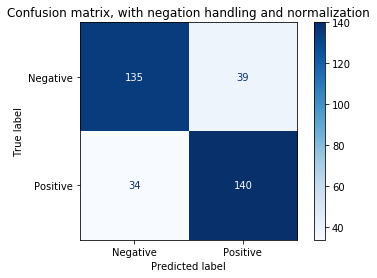

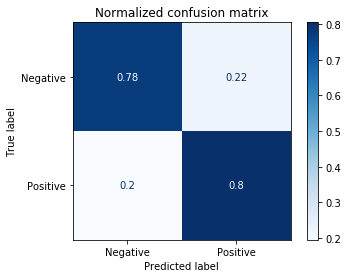

In [38]:
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, with negation handling and normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(text_classifier, X_test, y_test,
                                 display_labels=['Negative','Positive'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Error analysis negation handling

In [39]:
def custompreprocessing(tweet):
    word_tokens = word_tokenize(tweet)
    negation_word = []
    negated_word = []
    negation_word_list = ["tidak","tanpa","tak","belum","kurang"]
    for x in range(len(word_tokens)):
        if word_tokens[x] in negation_word_list:
            if(x+1 < len(word_tokens)):
                sentence = word_tokens[x] + " " + word_tokens[x+1]
                sentence_1 = "not" + "_" + word_tokens[x+1]
                negation_word.append(sentence)
                negated_word.append(sentence_1)
    for x in range(len(negation_word)):
        if(negation_word[x] in tweet):
            tweet = tweet.replace(negation_word[x],negated_word[x])
    return tweet

In [40]:
def cuspreprocessing(tweet):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    negation_word_list = ["tidak","tanpa","tak","belum","kurang"]
    negation_word = []
    negated_word = []
    count = 0
    for row in tweet:
        #print("before : ",row['tweet'])
        #convert sentence in lowercase
        row = row.lower()
        row = re.sub('[^A-Za-z0-9 ]+','', row)
        # remove number
        row = re.sub('[0-9]+', '', row)
        row = re.sub(r'\d+', '', row)
        #Convert www.* or https?://* to URL
        row = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',row)
        row = re.sub(r"pictwittercom(\w+)", '',row)
        #remove hastag word
        row = re.sub(r"#(\w+)", '',row)
        #remove atuser words
        row = row.replace('atuser','')
        
        #Tokenize
        word_tokens = word_tokenize(row)
        #negation handling
        for x in range(len(word_tokens)):
            if word_tokens[x] in negation_word_list:
                if(x+1 < len(word_tokens)):
                    sentence = word_tokens[x] + " " + word_tokens[x+1]
                    sentence_1 = "not" + "_" + word_tokens[x+1]
                    negation_word.append(sentence)
                    negated_word.append(sentence_1)
                    print(negation_word, " -> ",negated_word)
                    count = count + 1
        for x in range(len(negation_word)):
            if(negation_word[x] in row):
                row = row.replace(negation_word[x],negated_word[x])
        word_tokens = word_tokenize(row)
        #Stop word removal
        filtered_sentence = [w for w in word_tokens if not w in stopWords]
        row = " ".join(filtered_sentence)
        
        #stemming
        filtered = [] 
        for v in filtered_sentence:
            if "not" not in v:
                filtered.append(stemmer.stem(v))
            if "not" in v:
                filtered.append(v)
        row = " ".join(filtered)
        
    print("total tweet with negation : ",count)
    return row

The function above is created to detect negation in single tweet text and transform negated word into "NOT_"  + word.

In [41]:
neg = []
neg_log_proba = []
pos = []
pos_log_proba = []
for row in neg_dict:
    if("not_" in row):
        neg.append(row)
        neg_log_proba.append(neg_dict[row])

for row in pos_dict:
    if("not_" in row):
        pos.append(row)
        pos_log_proba.append(pos_dict[row])

In [42]:
d = {'feature':neg, "negative log proba":neg_log_proba,"positive log proba":pos_log_proba}
df_log_proba = pd.DataFrame(d)
df_log_proba.head()

,feature,negative log proba,positive log proba
0,not_acara,-8.966066,-8.730643
1,not_ajar,-8.391479,-8.981707
2,not_alas,-8.966066,-8.981707
3,not_alih,-8.966066,-8.666293
4,not_ambil,-8.966066,-8.714337


The cell above shows the log probability of feature

In [43]:
print("log probability of prior class : ", text_classifier.class_log_prior_)

log probability of prior class :  [-0.69314718 -0.69314718]


In [44]:
test_text = ["tidak ambil"]
new_test_text = custompreprocessing(test_text[0])
predict = text_classifier.predict(tfidf_vectorizer.transform([new_test_text]))
log_proba_predict = text_classifier.predict_proba(tfidf_vectorizer.transform([new_test_text]))
print(new_test_text)
print("classified as : ",predict)
print("log probability :",log_proba_predict)


not_ambil
classified as :  ['positive']
log probability : [[0.43739805 0.56260195]]


In [161]:
test_text = ["tidak adaaaaaaa"]
new_test_text = custompreprocessing(test_text[0])
predict = text_classifier.predict(tfidf_vectorizer.transform([new_test_text]))
log_proba_predict = text_classifier.predict_proba(tfidf_vectorizer.transform([new_test_text]))
print(new_test_text)
print("classified as : ",predict)
print("log probability :",log_proba_predict)


ValueError: dimension mismatch

The classification of text "tidak ambil" is based on calculation of log probability of feautre.
Since the feature of "tidak ambil" is more higher in positive log proba column, the model will classified this text as positive.

If the feature is not listed on feature list the model will classified the feature as positive. The classification model classified the text of "tidak adaaaaaaa" because there is no feature of "not_adaaaaa" in the feature list. Since the log prior class of positive higher than negative class, this cause the model classified a document which has no feature in the model as positive.

Since this model is created only from 1800 tweets and only 380 tweets contain negation word, this model still need to be enhancted by adding more negation data.



## Error analysis word order

In [46]:
test_text = ["tidak untuk saat ini tapi , saya senang "]
test_text_after = cuspreprocessing(test_text)
predict = text_classifier.predict(tfidf_vectorizer.transform([test_text_after]))
print(test_text_after)
print(predict)

['tidak untuk']  ->  ['not_untuk']
total tweet with negation :  1
not_untuk tapi senang
['negative']


In [47]:
test_text = ["saya senang, tapi tidak untuk saat ini "]
test_text_after = cuspreprocessing(test_text)
predict = text_classifier.predict(tfidf_vectorizer.transform([test_text_after]))
print(test_text_after)
print(predict)

['tidak untuk']  ->  ['not_untuk']
total tweet with negation :  1
senang tapi not_untuk
['negative']


the test text on first cell with text "tidak untuk saat ini tapi, saya senang" (not for now, but i am happy) is classified as negative, however if we evaluate the text, it should be classified as positive.
naive bayes ignore word order for text classification problems.

In [48]:
for word in pos_dict:
    print(word, pos_dict[word])

aaaaaaarrrrgggghh -8.981707393016322
abah -8.981707393016322
abai -8.789439954217649
abang -8.466653272235433
abdi -8.534030310983471
abdul -8.77249221886076
abdulhalimiskandar -8.669399601755513
abdullah -8.691247352417479
abet -8.981707393016322
abis -8.981707393016322
abnormal -8.981707393016322
about -8.981707393016322
absah -8.666104464056627
abu -8.981707393016322
abuse -8.981707393016322
abuseofpower -8.981707393016322
academy -8.711463892930267
acara -8.100589681701791
aceh -8.12498657533482
acehhebat -8.51450440496618
achmad -8.781161153265131
actress -8.782788649500974
acu -8.550839909794787
acuh -8.754397442764361
adaada -8.981707393016322
adain -8.981707393016322
adaptasi -8.981707393016322
adek -8.981707393016322
adil -8.782956693271062
admin -8.612913946153077
administrasi -8.981707393016322
adu -8.078267849762165
aduh -8.981707393016322
adventure -8.981707393016322
aerobik -8.981707393016322
again -8.720880023734694
agam -8.61269847535537
agama -8.176505685383853
agen -8

dedjawatan -8.755634338248813
dedy -8.702591604011747
defisit -8.981707393016322
degan -8.687731311130621
degil -8.981707393016322
dekat -8.55290008673024
dekatdihati -8.022369555599475
dekdekan -8.780840965458706
delapan -8.401429119486775
demi -8.981707393016322
demojakarta -8.981707393016322
demokrasi -8.372873434178421
demokrasitirasi -8.981707393016322
demomusisi -8.981707393016322
demosantuy -8.981707393016322
denda -8.981707393016322
denganindonesiakaminurutindonesiamelawancoviddirumahaja -8.709754978386526
dengar -8.981707393016322
denger -8.981707393016322
dengerin -8.981707393016322
dengernya -8.981707393016322
denmark -8.77548026316559
depan -8.078552622309171
depok -8.343259380714855
depokinfo -8.706573728021713
depokupdate -8.706573728021713
deprovgorontalo -8.981707393016322
derita -8.981707393016322
derrysulaiman -8.981707393016322
desa -7.06224939354736
desacemplang -8.721158192802392
desain -8.221731227864153
desak -8.981707393016322
desakelurahan -8.74338338629456
des

kartuprakerja -7.112465323649671
kartuprakerjajokowi -8.981707393016322
kartusembako -8.659031962510003
karung -8.981707393016322
karya -8.008148305013217
karyasiswaskm -8.981707393016322
karyawan -8.981707393016322
karyawannya -8.699880122613305
karyawant -8.753829691376891
kas -8.745930302687047
kasar -8.981707393016322
kasi -8.758716454043084
kasih -7.687226542369043
kasihan -8.981707393016322
kasim -8.746019586234247
kasus -8.981707393016322
kasusny -8.981707393016322
kasusnyasblm -8.981707393016322
kat -8.981707393016322
kata -8.75252598433841
katabijak -8.981707393016322
katahati -8.981707393016322
katakata -8.981707393016322
katapuan -8.981707393016322
kategori -8.661657306798931
katolik -8.218054676320111
kaum -8.700103776319917
kaw -8.981707393016322
kawa -8.981707393016322
kawal -8.755697392883238
kawalcovid -8.981707393016322
kawan -8.440947094388317
kawankabinet -8.981707393016322
kawasan -8.462619847543037
kaya -8.981707393016322
kayu -8.981707393016322
kcwli -8.9817073930

not_kenal -8.683135156098574
not_kendali -8.981707393016322
not_kenek -8.981707393016322
not_keras -8.590034633556087
not_kerja -8.981707393016322
not_kerumun -8.742173754142007
not_kitu -8.981707393016322
not_klaim -8.981707393016322
not_kompak -8.981707393016322
not_konflik -8.981707393016322
not_konsisten -8.981707393016322
not_koreksi -8.981707393016322
not_kritik -8.981707393016322
not_kumpul -8.736109872647903
not_kumpulkumpul -8.981707393016322
not_kunjung -8.981707393016322
not_lak -8.981707393016322
not_laksana -8.727858816722822
not_landas -8.981707393016322
not_larang -8.981707393016322
not_layak -8.724980004291695
not_lemah -8.981707393016322
not_lepas -8.981707393016322
not_lgsung -8.763870896230731
not_liat -8.792261630372222
not_lihat -8.981707393016322
not_lockdown -8.981707393016322
not_lolos -8.981707393016322
not_lupa -8.703577130769252
not_luput -8.981707393016322
not_mahal -8.628612096209704
not_main -8.713649277782254
not_makan -8.981707393016322
not_maksimal -8.9

saringsebelumsharing -8.732699251896829
sarini -8.981707393016322
sasar -7.291166313445229
sat -8.981707393016322
sateratu -8.981707393016322
satgas -8.981707393016322
satgascovid -8.737299875115946
satgaskom -8.743330238993014
satpolppkotadepok -8.706573728021713
satreskrim -8.736040417161696
satron -8.981707393016322
satu -7.524422215700861
satudata -8.683222565937958
satuny -8.76707744956776
satusatunya -8.49602796011923
saudara -7.634499194510331
saudarasaudara -8.655220506889062
saudarasaudari -8.981707393016322
saveathome -8.683135156098574
saveindonesia -8.981707393016322
savemusisi -8.981707393016322
saver -8.981707393016322
savetenagakesehatanindonesiaterserah -8.981707393016322
savetenagamedis -8.46013225814217
savetimmedisindonesia -8.69525784473641
sawangan -8.669019495699846
sawar -8.66974942048929
sawit -8.734863500018717
sayabersyukur -8.704701911241932
sayang -8.067900453811061
sayapancasila -8.981707393016322
sayasaya -8.627718201976442
scientist -8.981707393016322
sd 

uwe -8.981707393016322
uwuan -8.981707393016322
vaksin -8.762437595931411
valid -8.981707393016322
vangkesaya -8.981707393016322
variasi -8.981707393016322
variatif -8.721102387301995
vasenya -8.981707393016322
vektora -8.70431600160598
vendor -8.431572582345721
ventura -8.705346538068529
verifikasi -8.33230864258884
versi -8.710559159757342
verval -8.69065835782484
vi -8.981707393016322
vialexaandrea -8.7290427760589
vida -8.981707393016322
video -8.05780675915665
videokawani -8.593900172310848
videolucu -8.981707393016322
videolucubanget -8.981707393016322
videoviral -8.732480794882026
viii -8.586029696472352
vinus -8.981707393016322
viral -7.772967015485098
viralindonesia -8.676889426149932
viralnenek -8.981707393016322
viralnya -8.981707393016322
viralvideo -8.981707393016322
virtual -8.465508622482993
virtualdigital -8.981707393016322
virus -7.339439433142249
viruscorna -8.981707393016322
viruscorona -8.185690810555453
vit -8.71621380043906
viva -8.981707393016322
vivanews -8.9817

# Data visualization

### Wordcloud for postive and negative tweets

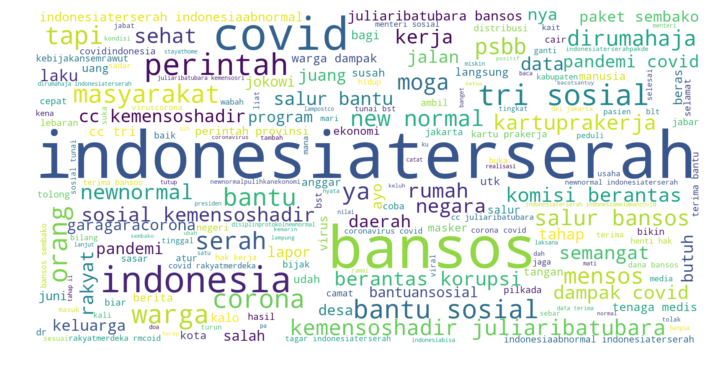

In [49]:
tweet = ''
for row in dataset:
    tweet  = tweet + row['tweet'] + " "
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,background_color='white').generate(tweet)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Wordcloud positive tweet

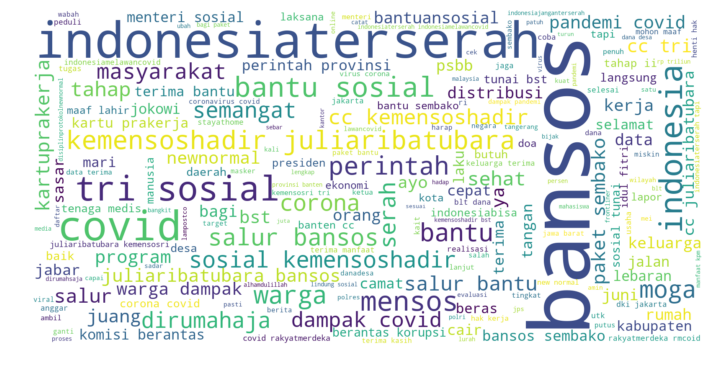

In [50]:
positive_tweet = ''
for row in dataset:
    if row['intent'] == 'positive':
        positive_tweet  = positive_tweet + row['tweet'] + " "
positive_tweet = positive_tweet.replace('atuser ', '')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,background_color='white').generate(positive_tweet)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Wordcloud negative tweet

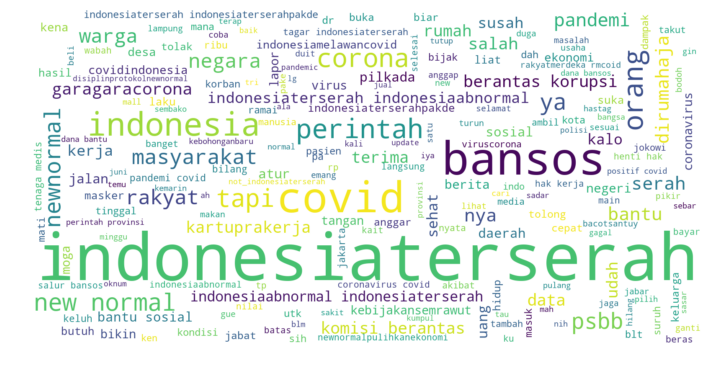

In [51]:
negative_tweet = ''
for row in dataset:
    if row['intent'] == 'negative':
        negative_tweet  = negative_tweet + row['tweet'] + " "
negative_tweet = negative_tweet.replace('at_user ', '')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,background_color='white').generate(negative_tweet)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Hashtag Visualization

In [52]:
def hashtagPreprocessing(dataset):
    # create stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    count = 0
    for row in dataset:
        #print("before : ",row['tweet'])
        #convert sentence in lowercase
        row['hashtag'] = row['hashtag'].lower()
        row['tweet'] = re.sub('[^A-Za-z0-9 ]+','', row['tweet'])
        #remove bracket
        row['hashtag'] = row['hashtag'].replace('[','')
        row['hashtag'] = row['hashtag'].replace(']','')
        #remove #
        row['hashtag'] = row['hashtag'].replace('#','')
        #remove '
        row['hashtag'] = row['hashtag'].replace("'",'')
        row['hashtag'] = row['hashtag'].replace(",",' ')
hashtagPreprocessing(dataset)

##### Code above is to remove unnecessary symbols such as ', #, [ and ] on hastag's column

In [53]:
hashtag = []
for row in dataset:
    word_tokens = word_tokenize(row['hashtag']) 
    for x in range(len(word_tokens)):
        hashtag.append(word_tokens[x])
print(Counter(hashtag))

Counter({'indonesiaterserah': 944, 'bansos': 704, 'covid19': 205, 'kemensoshadir': 101, 'juliaribatubara': 97, 'kemensos': 91, 'covid': 83, 'dirumahaja': 82, '?': 71, 'indonesiaabnormal': 69, 'newnormal': 66, 'kartuprakerja': 62, 'corona': 57, 'covid_19': 55, 'coronavirus': 52, 'indonesiamelawancovid19': 45, 'å¸â¬19': 43, 'indonesia': 38, 'garagaracorona': 32, 'kpk': 31, 'bst': 31, 'covid__19': 30, 'bantuansosial': 29, 'indonesiaterserahpakde': 29, 'kebijakansemrawut': 27, 'psbb': 27, 'mensos': 26, 'covid19indonesia': 26, 'rakyatmerdeka': 24, 'rmcoid': 24, 'blt': 22, 'banten': 21, 'lawancovid19': 21, 'indonesiabisa': 18, 'jokowi': 18, 'lampostco': 18, 'indonesiaambyar': 18, 'viruscorona': 17, 'stayathome': 16, 'newnormalpulihkanekonomi': 16, 'disiplinprotokolnewnormal': 15, 'kebohonganbaru': 15, 'indonesiajanganterserah': 15, 'jabar': 14, 'jakarta': 14, 'sembako': 14, 'bacotsantuy': 13, 'dirumahsaja': 13, 'newnormalindonesia': 13, 'jagajarak': 13, 'pilkada2020': 12, 'danadesa': 11, 'pr

##### Tokenize each hastagh and store in array hastag
##### by runnning this commented line "#print(Counter(hashtag))", we can get the frequencies of hastags used on the dataset

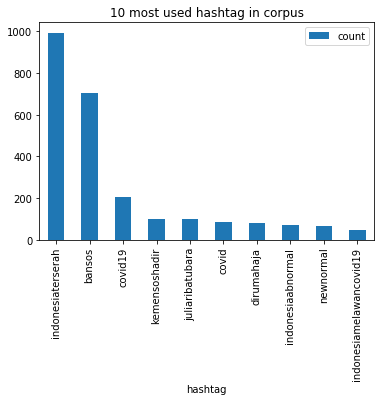

In [54]:
from pandas import DataFrame
Data = {'hashtag': [],
        'count': []
       }
dfHashtag = DataFrame(Data,columns=['hashtag','count'])
dfHashtag = dfHashtag.append(pd.DataFrame([["indonesiaterserah",994],["bansos",704],["covid19",205],["kemensoshadir",101],["juliaribatubara",97],
                                          ["covid",83],["dirumahaja",82],["indonesiaabnormal",69],["newnormal",66],["indonesiamelawancovid19",45],
                                          ],columns=dfHashtag.columns),ignore_index=True)
dfHashtag = dfHashtag.astype({'hashtag': 'str', 'count': 'int'})
dfHashtag
# a simple line plot
dfHashtag.plot(kind='bar',x='hashtag',y='count',title="10 most used hashtag in corpus")

In [55]:
positive_tweet = []
for row in dataset:
    if row['intent'] == 'positive':
        word_tokens = word_tokenize(row['tweet']) 
        for x in range(len(word_tokens)):
            #check if word used in hashtag
            #if word_tokens[x] not in hashtag:
            positive_tweet.append(word_tokens[x])
#print(Counter(positive_tweet))

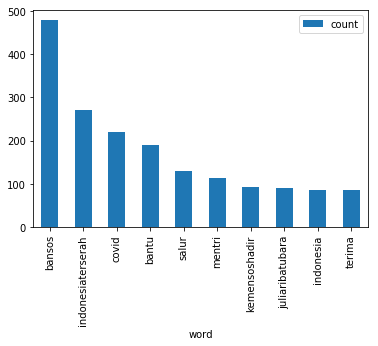

In [56]:
Data = {'word': [],
        'count': []
       }
dfPositive = DataFrame(Data,columns=['word','count'])
dfPositive = dfPositive.append(pd.DataFrame([["bansos",478],["indonesiaterserah",271],["covid",219],["bantu",190],["salur",129],["mentri",113],
                                          ["kemensoshadir",94],["juliaribatubara",91],["indonesia",86],["terima",86]
                                          ],columns=dfPositive.columns),ignore_index=True)
dfPositive = dfPositive.astype({'word': 'str', 'count': 'int'})
dfPositive
# a simple line plot
dfPositive.plot(kind='bar',x='word',y='count')

In [57]:
negative_tweet = []
for row in dataset:
    if row['intent'] == 'negative':
        word_tokens = word_tokenize(row['tweet']) 
        for x in range(len(word_tokens)):
            #check if word used in hashtag
            #if word_tokens[x] not in hashtag:
            negative_tweet.append(word_tokens[x])
#print(Counter(negative_tweet))

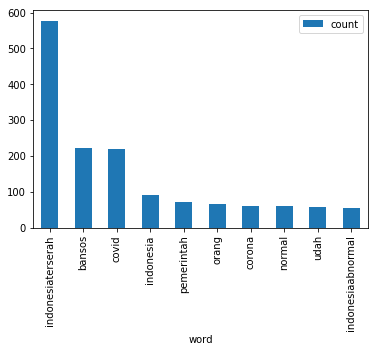

In [58]:
Data = {'word': [],
        'count': []
       }
dfNegative = DataFrame(Data,columns=['word','count'])
dfNegative = dfNegative.append(pd.DataFrame([["indonesiaterserah",577],["bansos",224],["covid",221],["indonesia",92],["pemerintah",72],["orang",67],
                                          ["corona",60],["normal",60],["udah",57],["indonesiaabnormal",55]
                                          ],columns=dfNegative.columns),ignore_index=True)
dfNegative = dfNegative.astype({'word': 'str', 'count': 'int'})
dfNegative
# a simple line plot
dfNegative.plot(kind='bar',x='word',y='count')